Trying to filter small populatino fragments to get a measure of ILS in windows.

In [1]:
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

In [16]:
# Functions to generate the painting dataframes and identify proportion of short fragments.

def length_to_windows_ils(length_df, window_size=100000, ils_filter=2000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    length_df = length_df.loc[length_df.paint_length < ils_filter]
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            overall_dict[row["pop"]][i] += sum(s_df.paint_length)
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if hap == 1:
                hap = 2
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [5]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
chrom_list = ["X"] # ["8", "X"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique())[1:]:
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        df_l.append(length_df)
df = pd.concat(df_l)

anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [17]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
chrom_list = ["X"] # ["8", "X"] # ["X"]
os.makedirs("../steps/paint_summary/", exist_ok=True)
#df.to_csv("../steps/paint_summary/paint_lengths.txt")
df = pd.read_csv("../steps/paint_summary/paint_lengths.txt")
df = df.iloc[:,1:]

In [51]:
df.paint_length.median()

7927.0

In [52]:
window_length = 100000
ils_length = df.paint_length.median()
ils_d = {}
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique())[1:]:
        ils_l = []
        print(population)
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_"+ind+"_ils.txt"
            window_df = length_to_windows_ils(df.loc[(df.individual==ind)], window_size=window_length, ils_filter=ils_length)
            window_df["PGDP_ID"] = ind
            ils_l.append(window_df)
        ils_df = pd.concat(ils_l)
        ils_d[population] = ils_df

anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [53]:
for population in ils_d:
    ils_d[population].to_csv("../steps/paint_summary/ils_df_{}.txt".format(population), index=False)

In [54]:
ils_d["anubis_tanzania"]

,windows,anubis_ethiopia,cyno_central,cyno_western,hamadryas,kindae,papio,ursinus,PGDP_ID
0,2500022,122136.0,0.0,2198448.0,0.0,0.0,0.0,1221360.0,PD_0199
1,2600022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0199
2,2700022,5892.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0199
3,2800022,232374.0,77458.0,154916.0,77458.0,1394244.0,0.0,0.0,PD_0199
4,2900022,592424.0,0.0,0.0,253896.0,84632.0,846320.0,0.0,PD_0199
...,...,...,...,...,...,...,...,...,...
1407,143200022,29654.0,0.0,0.0,0.0,0.0,14827.0,0.0,PD_0686
1408,143300022,147655.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0686
1409,143400022,220120.0,22012.0,0.0,44024.0,88048.0,22012.0,0.0,PD_0686
1410,143500022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0686


Horizonplot

In [55]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin

In [56]:
pop_inv = "anubis_tanzania"
ils_df = ils_d[pop_inv]
ils_df["pop"] = ils_df["PGDP_ID"].map(mapping)
ils_df["start"] = ils_df["windows"]
ils_df["chrom"] = "chrX"
mean_ils = ils_df.iloc[:,1:8].sum(axis=1).mean()
ils_df["ils"] = (ils_df.iloc[:,1:8].sum(axis=1))

In [57]:
ils_df

,windows,anubis_ethiopia,cyno_central,cyno_western,hamadryas,kindae,papio,ursinus,PGDP_ID,pop,start,chrom,ils
0,2500022,122136.0,0.0,2198448.0,0.0,0.0,0.0,1221360.0,PD_0199,"Serengeti, Tanzania",2500022,chrX,3541944.0
1,2600022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0199,"Serengeti, Tanzania",2600022,chrX,0.0
2,2700022,5892.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0199,"Serengeti, Tanzania",2700022,chrX,5892.0
3,2800022,232374.0,77458.0,154916.0,77458.0,1394244.0,0.0,0.0,PD_0199,"Serengeti, Tanzania",2800022,chrX,1936450.0
4,2900022,592424.0,0.0,0.0,253896.0,84632.0,846320.0,0.0,PD_0199,"Serengeti, Tanzania",2900022,chrX,1777272.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,143200022,29654.0,0.0,0.0,0.0,0.0,14827.0,0.0,PD_0686,"Lake Manyara, Tanzania",143200022,chrX,44481.0
1408,143300022,147655.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0686,"Lake Manyara, Tanzania",143300022,chrX,147655.0
1409,143400022,220120.0,22012.0,0.0,44024.0,88048.0,22012.0,0.0,PD_0686,"Lake Manyara, Tanzania",143400022,chrX,396216.0
1410,143500022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0686,"Lake Manyara, Tanzania",143500022,chrX,0.0


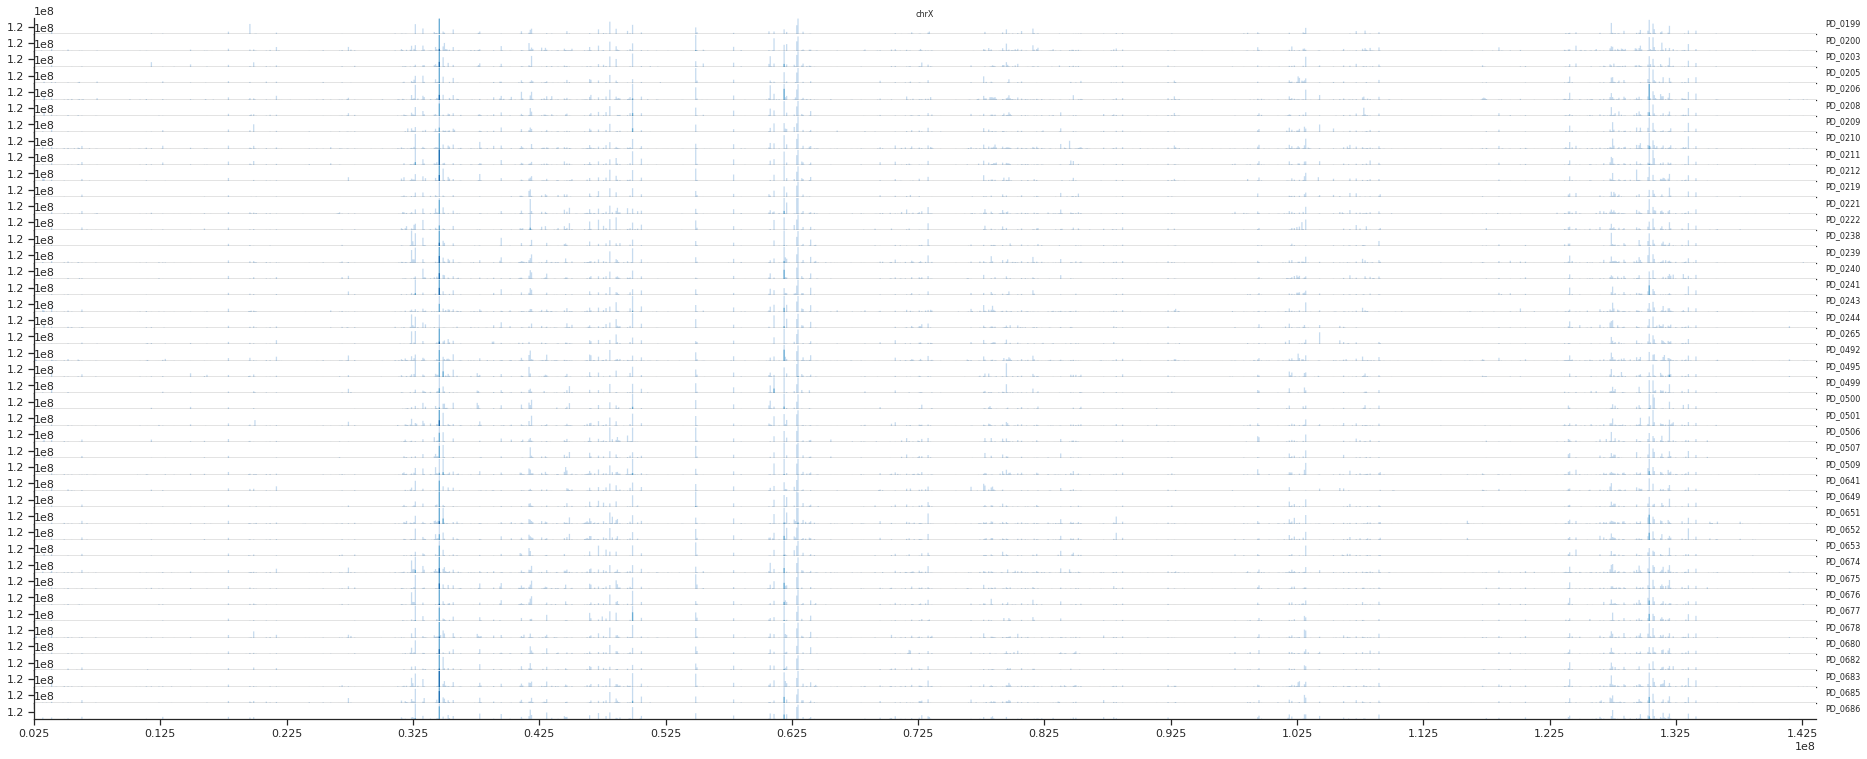

In [58]:
fig = horizonplot(ils_df, 'ils', width=2, col='chrom', row='PGDP_ID', size=0.3, aspect=100)